In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
from model import UNet

from utils import *

c:\Users\joeag\Documents\venvs\ml-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

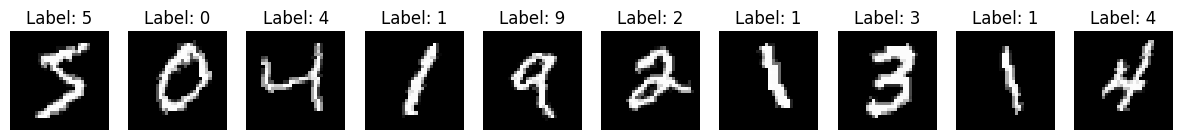

Max value: tensor(2.8215, device='cuda:0')
Min value: tensor(-0.4242, device='cuda:0')


In [3]:
dataset = datasets.MNIST(root='../Datasets/', train=True, transform=transforms.ToTensor(), download=True)
t_dataset = datasets.MNIST(root='../Datasets/', train=False, transform=transforms.ToTensor(), download=True)

# VAL_RATIO = 0.0
# n_val = int(len(dataset) * VAL_RATIO)
# n_train = len(dataset) - n_val
# train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])

class SigmoidTransform(object):
    def __call__(self, tensor):
        return 1 / (1 + torch.exp(-tensor))

class TanhTransform(object):
    def __call__(self, tensor):
        return torch.tanh(tensor)

class PadTransform(object):
    def __call__(self, tensor):
        return F.pad(tensor, (2,2,2,2), mode='constant', value=0)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    PadTransform(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform(),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    PadTransform(),
    transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform()
])

train_set = PreloadedDataset.from_dataset(dataset, train_transform, device)
# val_set = PreloadedDataset.from_dataset(val_set, val_transform, device)
# test_set = PreloadedDataset.from_dataset(t_dataset, val_transform, device)

# Show example images
fig, axes = plt.subplots(1, 10, figsize=(15,5))
for i, ax in enumerate(axes):
    img, label = train_set[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.show()

# print max and min values
print('Max value:', train_set.transformed_images.max())
print('Min value:', train_set.transformed_images.min())

In [4]:
IMG_SIZE = 32
BATCH_SIZE = 64
timesteps = 16
time_bar = 1 - torch.linspace(0, 1.0, timesteps+1)

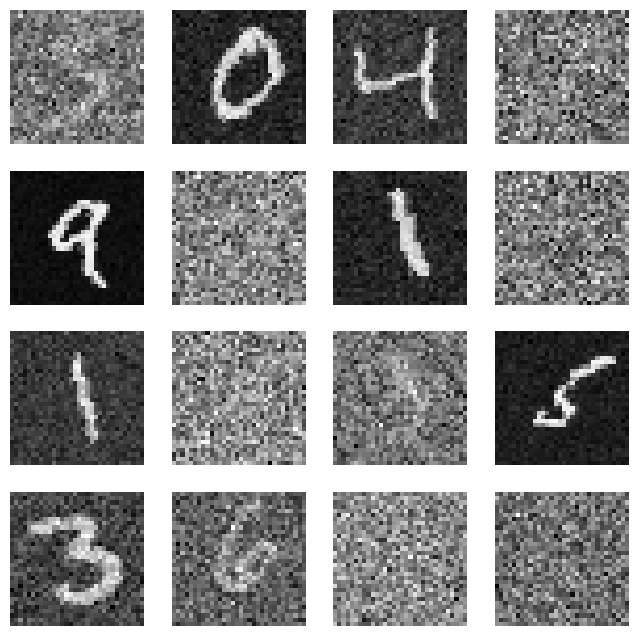

In [5]:
def forward_noise(x, t):
    a = time_bar[t].unsqueeze(2).unsqueeze(3).to(device).expand_as(x)
    b = time_bar[t+1].unsqueeze(2).unsqueeze(3).to(device).expand_as(x)

    noise = torch.randn_like(x).to(device)
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b

    return img_a, img_b

def generate_ts(num):
    return torch.randint(0, timesteps, (num,1))

num = 16
t = generate_ts(num)
a, b = forward_noise(train_set[0:num][0], t)
showExamples(a)

In [12]:
def train(
        model,
        train_set,
        optimiser,
        criterion,
        num_epochs=10,
):
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    for epoch in range(num_epochs):
        train_set.apply_transform()

        epoch_loss = 0.0
        loop = tqdm(train_loader, total=len(train_loader), leave=False)

        for data, _ in loop:

            ts = generate_ts(data.shape[0]).to(device)
            x_a, x_b = forward_noise(data, ts.to('cpu'))
            y_p = model(x_a, ts)

            loss = criterion(y_p, x_b)
            epoch_loss += loss.item()

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            if epoch > 0:
                loop.set_postfix(loss=losses[-1])

        losses.append(epoch_loss / len(train_loader))

In [13]:
model = UNet().to(device)
optimiser = torch.optim.AdamW(model.parameters(), lr=0.0005)
# criterion = torch.nn.MSELoss()
criterion = torch.nn.L1Loss()

In [14]:
train(model, train_set, optimiser, criterion, num_epochs=30)

100%|██████████| 16/16 [00:00<00:00, 299.49it/s]


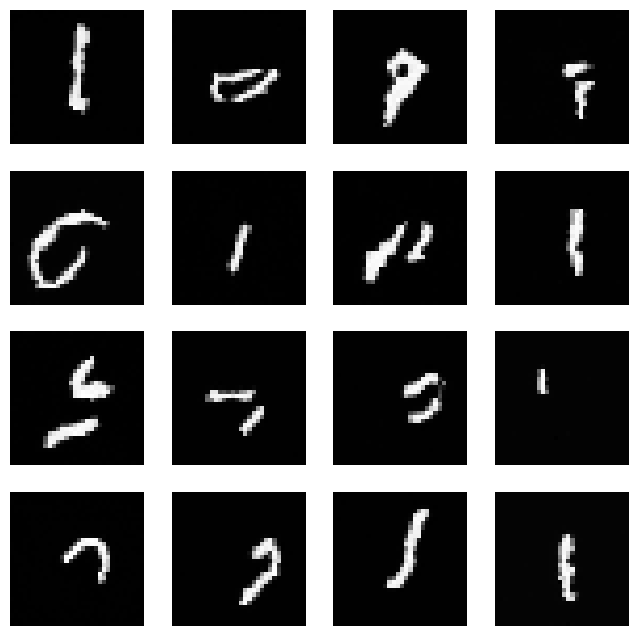

In [21]:
def sample(model, timesteps=16):
    x = torch.randn((16, 1, 32, 32)).to(device)

    with torch.no_grad():
        for t in trange(timesteps):
            x = model.forward(x, torch.full([16, 1], t, dtype=torch.float32, device=device))

    showExamples(x)
sample(model)

100%|██████████| 16/16 [00:00<00:00, 327.69it/s]


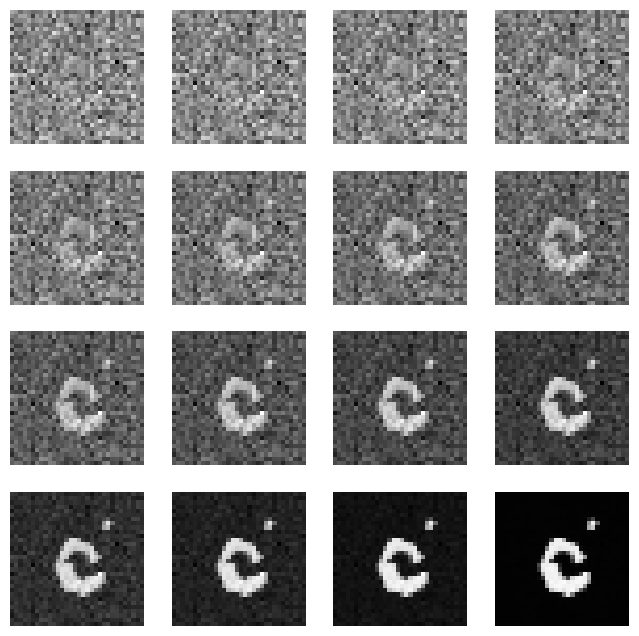

In [26]:
def sample_steps(model, timesteps=16):
    xs = []
    x = torch.randn((1, 1, 32, 32)).to(device)

    with torch.no_grad():
        for t in trange(timesteps):
            x = model.forward(x, torch.full([1, 1], t, dtype=torch.float32, device=device))
            xs.append(x)
    
    showExamples(xs)

sample_steps(model, timesteps=16)